In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
import xgboost as xgb

In [3]:
xgb.__version__

'1.1.1'

In [4]:
DATA_DIR_PATH = os.path.join('..', '..', 'data')

def laod_data(file_name):
  file_path = os.path.join(DATA_DIR_PATH, file_name)
  return pd.read_csv(file_path, header=0)

In [5]:
df_train = laod_data('bookmark_train_data.csv')
print(len(df_train))
df_train.head(3)

199


,ncode,title,category,bookmark_cat,created_at,updated_at,sum_char_count,sum_new_line_count,sum_talk_char_count,sum_word_count,...,wc_その他-間投,wc_名詞-固有名詞-人名-名,wc_助動詞,wc_助詞-接続助詞,wc_名詞-代名詞-一般,wc_副詞-一般,wc_名詞-接続詞的,wc_名詞-固有名詞-組織,wc_記号-句点,rating
0,n4366gd,雷帝の軌跡 ～俺だけ使える【雷魔術】で最強の魔術師を目指します～,ハイファンタジー〔ファンタジー〕,1,1.586338e+09,1.593468e+09,92340,3840,28950,992220,...,0,30,4680,2250,900,570,0,0,1830,3.0
1,n7336gg,星斬りの剣士,ハイファンタジー〔ファンタジー〕,1,1.590714e+09,1.593338e+09,77880,4140,4950,863400,...,0,90,4320,1620,1590,390,0,60,2280,4.0
2,n9677fw,落ちこぼれ国を出る〜実は世界で４人目の付与術師だった件について〜,ハイファンタジー〔ファンタジー〕,1,1.575176e+09,1.593429e+09,59880,3090,10230,628470,...,0,240,2490,1260,450,360,30,0,930,3.0


In [6]:
# df_test = laod_data('ranking_test_data.csv')
# print(len(df_test))
# df_test.head(3)

In [7]:
from sklearn.preprocessing import LabelEncoder

cat_le = LabelEncoder()
cat_le.fit(df_train['category'])


def data_preprocess(df):
  new_df = df.drop(['ncode', 'title', 'bookmark_cat'], axis=1)

  new_df['category'] = cat_le.transform(new_df['category'])

  new_df['rating'] = new_df['rating'] * 10
  new_df = new_df.astype({'rating': 'int32'})

  kw_columns = [col for col in new_df.columns if col.find('kw_') != -1]
  new_df = new_df.drop(kw_columns, axis=1)

  wc_columns = [col for col in new_df.columns if col.find('wc_') != -1]
  new_df = new_df.drop(wc_columns, axis=1)

  return new_df

In [8]:
df_train2 = data_preprocess(df_train)
df_train2.head(3)

,category,created_at,updated_at,sum_char_count,sum_new_line_count,sum_talk_char_count,sum_word_count,avg_char_count,avg_new_line_count,avg_talk_char_count,avg_word_count,rating
0,6,1.586338e+09,1.593468e+09,92340,3840,28950,992220,3078.0,128.0,965.0,33074.0,30
1,6,1.590714e+09,1.593338e+09,77880,4140,4950,863400,2596.0,138.0,165.0,28780.0,40
2,6,1.575176e+09,1.593429e+09,59880,3090,10230,628470,1996.0,103.0,341.0,20949.0,30


In [9]:
X = df_train2.drop(['rating'], axis=1).values
y = df_train2['rating'].values
print(X.shape, y.shape)

(199, 11) (199,)


In [10]:
df_train2.keys()

Index(['category', 'created_at', 'updated_at', 'sum_char_count',
       'sum_new_line_count', 'sum_talk_char_count', 'sum_word_count',
       'avg_char_count', 'avg_new_line_count', 'avg_talk_char_count',
       'avg_word_count', 'rating'],
      dtype='object')

In [11]:
print(y)

u, counts = np.unique(y, return_counts=True)
print(len(u))
print(u)
print(counts)

[30 40 30 40 30 30 30 40 50 20 40 40 30 30 50 40 40 40 30 25 20 30 20 40
 40 40 35 30 20 20 40 30 40 20 30 20 35 20 20 30 35 35 35 10 30 45 75 60
 15 60 60 30 60 45 45 30 45 45 45 52 15 15 45 45 52 45 60 15 45 45 52 45
 45 75 45 45 52 60 52 67 60 45 45 60 52 45 52 67 60 52 10 15  5 17 15 10
 15 15 10 15 15 10  5 10 15 15 15 10 10 10 15 15 10 15 10 10 15  5  5  5
  5  5  5  5 10  5  5  5  5 10 15 10 15 15 10 10  5 15 10 10 15 15 15 10
  5  5 15 17 15 15 10 10 15 15 15 10  5  5 15 15 15 15 17 10 10 15 15 15
 15 15 15 15 10 15  5 15 17 15 17 15 15 15 15 15 10 15 15 15 15 15 15 15
 15 15 10 15 15 10 15]
15
[ 5 10 15 17 20 25 30 35 40 45 50 52 60 67 75]
[19 29 61  5  9  1 16  5 13 18  2  8  9  2  2]


### OverSampling

In [12]:
from imblearn.over_sampling import RandomOverSampler

In [13]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
print(X_resampled.shape, y_resampled.shape)

u, counts = np.unique(y_resampled, return_counts=True)
print(len(u))
print(u)
print(counts)

(915, 11) (915,)
15
[ 5 10 15 17 20 25 30 35 40 45 50 52 60 67 75]
[61 61 61 61 61 61 61 61 61 61 61 61 61 61 61]


In [14]:
import seaborn as sns

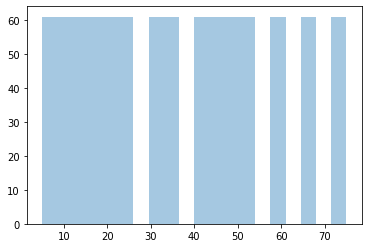

In [15]:
sns.distplot(y_resampled, kde=False, rug=False, bins=20)

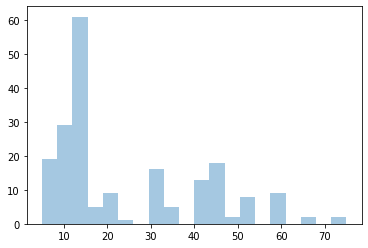

In [16]:
sns.distplot(y, kde=False, rug=False, bins=20)

In [17]:
from imblearn.over_sampling import SMOTE

In [18]:
smote = SMOTE(random_state=0)
#smote = SMOTE(random_state=0, k_neighbors=10)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(X_resampled.shape, y_resampled.shape)

u, counts = np.unique(y_resampled, return_counts=True)
print(len(u))
print(u)
print(counts)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 5, n_neighbors = 6

In [19]:
print(y_resampled)

[30 40 30 40 30 30 30 40 50 20 40 40 30 30 50 40 40 40 30 25 20 30 20 40
 40 40 35 30 20 20 40 30 40 20 30 20 35 20 20 30 35 35 35 10 30 45 75 60
 15 60 60 30 60 45 45 30 45 45 45 52 15 15 45 45 52 45 60 15 45 45 52 45
 45 75 45 45 52 60 52 67 60 45 45 60 52 45 52 67 60 52 10 15  5 17 15 10
 15 15 10 15 15 10  5 10 15 15 15 10 10 10 15 15 10 15 10 10 15  5  5  5
  5  5  5  5 10  5  5  5  5 10 15 10 15 15 10 10  5 15 10 10 15 15 15 10
  5  5 15 17 15 15 10 10 15 15 15 10  5  5 15 15 15 15 17 10 10 15 15 15
 15 15 15 15 10 15  5 15 17 15 17 15 15 15 15 15 10 15 15 15 15 15 15 15
 15 15 10 15 15 10 15  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17

In [20]:
pd.DataFrame(X_resampled[-15:])

,0,1,2,3,4,5,6,7,8,9,10
0,10.0,1.418559e+09,1.590678e+09,102390.0,4680.0,12930.0,1136460.0,3413.0,156.0,431.0,37882.0
1,6.0,1.437574e+09,1.498781e+09,64170.0,3090.0,11790.0,706830.0,2139.0,103.0,393.0,23561.0
2,6.0,1.437574e+09,1.498781e+09,64170.0,3090.0,11790.0,706830.0,2139.0,103.0,393.0,23561.0
3,6.0,1.437574e+09,1.498781e+09,64170.0,3090.0,11790.0,706830.0,2139.0,103.0,393.0,23561.0
4,6.0,1.437574e+09,1.498781e+09,64170.0,3090.0,11790.0,706830.0,2139.0,103.0,393.0,23561.0
5,6.0,1.437574e+09,1.498781e+09,64170.0,3090.0,11790.0,706830.0,2139.0,103.0,393.0,23561.0
6,10.0,1.418559e+09,1.590678e+09,102390.0,4680.0,12930.0,1136460.0,3413.0,156.0,431.0,37882.0
7,10.0,1.418559e+09,1.590678e+09,102390.0,4680.0,12930.0,1136460.0,3413.0,156.0,431.0,37882.0
8,10.0,1.418559e+09,1.590678e+09,102390.0,4680.0,12930.0,1136460.0,3413.0,156.0,431.0,37882.0
9,10.0,1.418559e+09,1.590678e+09,102390.0,4680.0,12930.0,1136460.0,3413.0,156.0,431.0,37882.0


In [21]:
from sklearn.model_selection import train_test_split

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, shuffle=True, random_state=1)

In [22]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(640, 11) (640,)
(275, 11) (275,)


In [23]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [24]:
print(dtrain.feature_names)

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']


In [25]:
xgb_params = {
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
}

evals = [(dtrain, 'train'), (dval, 'eval')]
evals_result = {}

bst = xgb.train(xgb_params,
                dtrain,
                num_boost_round=100,
                early_stopping_rounds=20,
                evals=evals,
                evals_result=evals_result)

[03:32:37] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:29.76990	eval-rmse:31.00711
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:22.08011	eval-rmse:22.90196
[2]	train-rmse:16.90751	eval-rmse:17.41018
[3]	train-rmse:13.39424	eval-rmse:13.93330
[4]	train-rmse:10.96607	eval-rmse:11.67492
[5]	train-rmse:8.78604	eval-rmse:9.72346
[6]	train-rmse:7.65950	eval-rmse:8.80588
[7]	train-rmse:6.37309	eval-rmse:8.01179
[8]	train-rmse:5.35860	eval-rmse:7.42152
[9]	train-rmse:4.99454	eval-rmse:7.27915
[10]	train-rmse:4.75826	eval-rmse:7.19530
[11]	train-rmse:4.48282	eval-rmse:7.12444
[12]	train-rmse:4.21933	eval-rmse:7.00120
[13]	train-rmse:3.94686	eval-rmse:6.92186
[14]	train-rmse:3.56144	eval-rmse:6.73520
[15]	train-rmse:3.21156	eval-rmse:6.65205
[16]	train-rmse:3.10907	eval-rmse:6.

In [26]:
import math
from sklearn.metrics import mean_squared_error

y_pred = bst.predict(dval)
mse = mean_squared_error(y_val, y_pred)
print('RMSE:', math.sqrt(mse))

RMSE: 5.4459037746250605


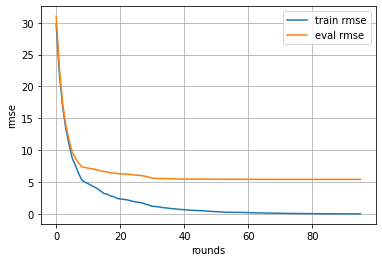

In [27]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')

eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')

plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

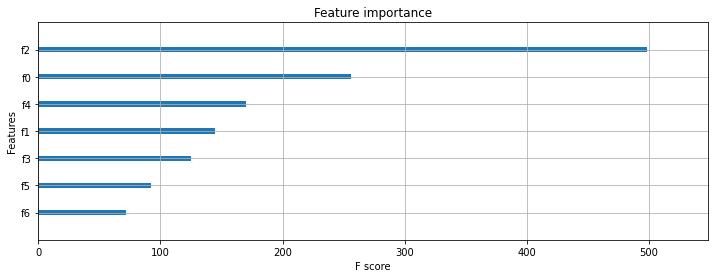

In [28]:
_, ax = plt.subplots(figsize=(12, 4))

xgb.plot_importance(bst,ax=ax,
                    importance_type='gain',
                    show_values=False)

plt.show()

{'f0': 'category', 'f1': 'created_at', 'f2': 'updated_at', 'f3': 'sum_char_count', 'f4': 'sum_new_line_count', 'f5': 'sum_talk_char_count', 'f6': 'sum_word_count', 'f7': 'avg_char_count', 'f8': 'avg_new_line_count', 'f9': 'avg_talk_char_count', 'f10': 'avg_word_count', 'f11': 'rating'}
{'updated_at': 420, 'sum_char_count': 330, 'category': 185, 'created_at': 720, 'sum_new_line_count': 271, 'sum_talk_char_count': 249, 'sum_word_count': 131}


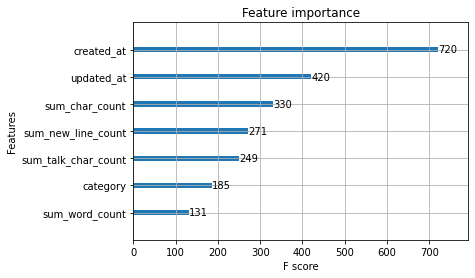

In [29]:
mapper = {'f{0}'.format(i): v for i, v in enumerate(df_train2.columns)}
print(mapper)

mapped = {mapper[k]: v for k, v in bst.get_fscore().items()}
print(mapped)

xgb.plot_importance(mapped)

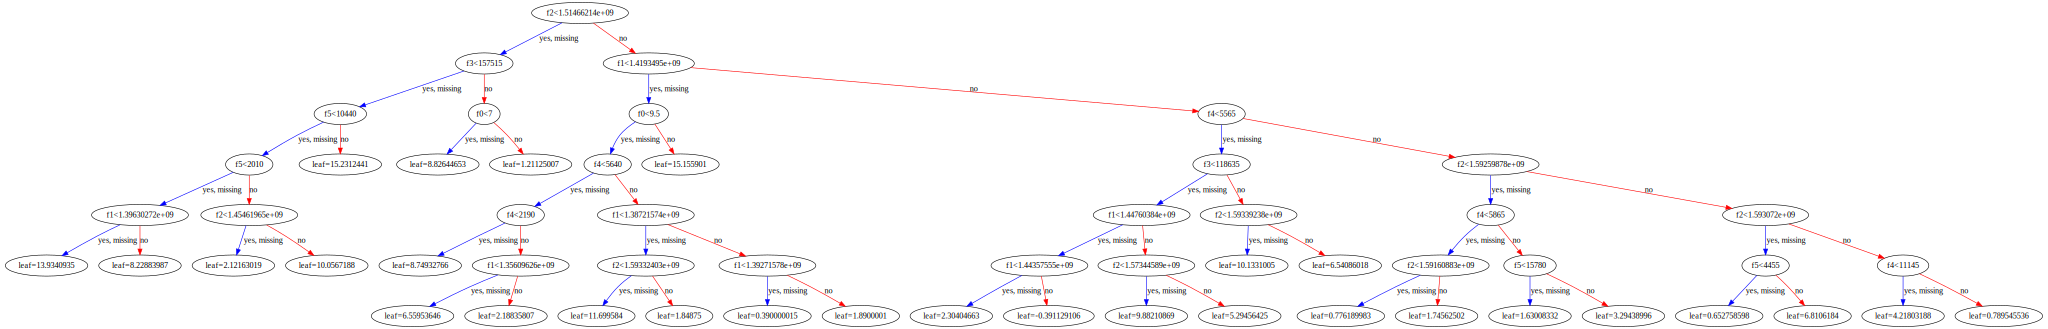

In [30]:
xgb.to_graphviz(bst, num_trees=1)

In [31]:
df_test = laod_data('ranking_test_data.csv')
print(len(df_test))
df_test.head(3)

65


,ncode,title,category,bookmark_cat,created_at,updated_at,sum_char_count,sum_new_line_count,sum_talk_char_count,sum_word_count,...,wc_動詞-非自立,wc_助詞-並立助詞,wc_接頭詞-数接続,wc_名詞-接続詞的,wc_形容詞-自立,wc_名詞-固有名詞-人名-一般,wc_記号-括弧開,wc_名詞-固有名詞-人名-名,wc_名詞-接尾-形容動詞語幹,rating
0,n8642gc,聖貨を集めて、ぶん回せ！,ハイファンタジー〔ファンタジー〕,-1,1.585469e+09,1.593763e+09,37740,2310,0,383130,...,30,240,0,0,270,30,480,60,0,-1
1,n8693gg,十年目、帰還を諦めた転移者はいまさら主人公になる,ハイファンタジー〔ファンタジー〕,-1,1.591009e+09,1.593774e+09,144330,5760,44100,1561170,...,1680,60,0,0,1710,0,1800,270,60,-1
2,n4452ge,俺だけレベルが上がる世界で悪徳領主になっていた,ハイファンタジー〔ファンタジー〕,-1,1.587737e+09,1.593006e+09,156720,6210,13290,1636680,...,1890,180,0,0,930,60,810,0,60,-1


In [32]:
df_test2 = data_preprocess(df_test)
df_test2.head(3)

,category,created_at,updated_at,sum_char_count,sum_new_line_count,sum_talk_char_count,sum_word_count,avg_char_count,avg_new_line_count,avg_talk_char_count,avg_word_count,rating
0,6,1.585469e+09,1.593763e+09,37740,2310,0,383130,1258.0,77.0,0.0,12771.0,-10
1,6,1.591009e+09,1.593774e+09,144330,5760,44100,1561170,4811.0,192.0,1470.0,52039.0,-10
2,6,1.587737e+09,1.593006e+09,156720,6210,13290,1636680,5224.0,207.0,443.0,54556.0,-10


In [33]:
X = df_test2.drop(['rating'], axis=1).values
y = df_test2['rating'].values
print(X.shape)

#dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X, label=y)
print(dtest)

(65, 11)


In [34]:
y_pred = bst.predict(dtest)
y_pred

array([42.881847 , 22.78999  , 36.695114 , 25.139954 , 42.26045  ,
       19.155884 , 24.845499 , 23.57384  , 36.787304 , 18.816242 ,
       34.68314  , 20.74351  , 44.235954 , 10.022871 , 17.352245 ,
       21.455708 , 26.814692 , 16.668756 , 24.836239 , 31.506792 ,
       21.477875 , 10.40856  , 24.824606 , 39.52018  , 17.99785  ,
       27.437225 , 20.732224 , 37.87893  , 33.391056 , 17.21532  ,
       21.15521  , 26.180658 , 27.120935 ,  5.91924  , 12.089307 ,
       33.68605  , 20.154604 , 14.264262 , 23.366358 ,  3.0185244,
       32.84702  , 27.45324  , 32.63355  , 32.6908   , 20.711115 ,
       18.083382 , 12.801122 , 29.94007  , 35.40743  , 25.702778 ,
       23.08883  , 46.87855  , 29.441607 , 21.845829 , 20.217234 ,
       25.532127 , 27.820595 , 21.354872 , 16.655733 , 28.152233 ,
       57.225613 , 20.89154  , 18.946112 , 35.86843  , 37.727512 ],
      dtype=float32)

In [35]:
df_rating = pd.DataFrame(columns=['ncode', 'title', 'rating'])

for i, y in enumerate(y_pred):
    row = df_test.loc[i] 
    print('{}\t{}\t{}'.format(row.ncode, row.title, y))
    df_rating = df_rating.append({'ncode': row.ncode, 'title': row.title, 'rating': y}, ignore_index=True)

n8642gc	聖貨を集めて、ぶん回せ！	42.8818473815918
n8693gg	十年目、帰還を諦めた転移者はいまさら主人公になる	22.789989471435547
n4452ge	俺だけレベルが上がる世界で悪徳領主になっていた	36.69511413574219
n8604ge	スキル「屋台」で異世界生活～食料生成スキルを手に入れたので、商会を立ち上げようと思います～	25.13995361328125
n6812gh	悪徳領主の息子に転生！？　～普通に行動しているだけなのに、周囲からちやほやされます～	42.26044845581055
n7408gf	異世界ゆるり農家生活	19.1558837890625
n0121gf	異世界へ来たのはいいけれど、モンスターと戦える程若くないおっさん。神様からもらったスキルは戦いにも生産にも役立たない。それでも生きる為に転々と渡り歩く	24.84549903869629
n4834fx	転生先が残念王子だった件　～今は腹筋１回もできないけど痩せて異世界救います～	23.57383918762207
n0512gh	『錬金BOX』で生産チート+付与無双～無能と罵られ侯爵家を追放されたが、なんでも錬成できる箱のおかげで勝ち組人生を送れそうです～	36.78730392456055
n4205gg	かませ犬から始める天下統一〜前世のアニメの第一部のボスに憑依してました〜	18.816242218017578
n1773gf	16年間魔法が使えず落ちこぼれだった俺が、科学者だった前世を思い出して異世界無双	34.68313980102539
n1217et	信者ゼロの女神サマと始める異世界攻略　クラスメイト最弱の魔法使い	20.74350929260254
n7657bb	かわいいコックさん	44.23595428466797
n5677cl	亡びの国の征服者～魔王は世界を征服するようです～	10.022871017456055
n5375cy	転生して田舎でスローライフをおくりたい	17.352245330810547
n2945eg	アラフォー男の異世界通販生活	21.455707550048828
n1118fh	加護なし令嬢の小さな村	26.8146915435791
n3191eh	乙女ゲー世界はモブに厳しい

In [36]:
df_rating.head()

,ncode,title,rating
0,n8642gc,聖貨を集めて、ぶん回せ！,42.881847
1,n8693gg,十年目、帰還を諦めた転移者はいまさら主人公になる,22.789989
2,n4452ge,俺だけレベルが上がる世界で悪徳領主になっていた,36.695114
3,n8604ge,スキル「屋台」で異世界生活～食料生成スキルを手に入れたので、商会を立ち上げようと思います～,25.139954
4,n6812gh,悪徳領主の息子に転生！？ ～普通に行動しているだけなのに、周囲からちやほやされます～,42.260448


In [37]:
df_rating.describe()

,rating
count,65.000000
mean,25.831113
std,10.015047
min,3.018524
25%,20.154604
50%,24.836239
75%,32.690800
max,57.225613


In [38]:
df_rating.var()

rating    100.301169
dtype: float64

In [39]:
df_rating.median()

rating    24.836239
dtype: float64